In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = Path('./open')
feature_dir = Path('./build/feature')
val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./open/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'
glove_file = './dataset/glove.6B/glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [3]:
algo_name = 'cnn'
feature_name = 'glove-lrs'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [4]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


<h2> 학습데이터 로드

In [5]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author,length
index,,,
0,He was almost choking. There was so much so mu...,3,235
1,Your sister asked for it I suppose,2,34
2,She was engaged one day as she walked in peru...,1,312
3,The captain was in the porch keeping himself c...,4,305
4,Have mercy gentlemen odin flung up his hands. ...,3,215


In [6]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<h2> Preprocessing

In [7]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "odin",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [8]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [9]:
train['length'] = train['text'].apply(len)

In [10]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,index,author,length
count,166641.000000,166641.000000,166641.000000
mean,92005.666649,2.045913,104.692315
std,52938.589914,1.293911,109.353860
min,0.000000,0.000000,20.000000
25%,46306.000000,1.000000,44.000000
50%,92135.000000,2.000000,72.000000
75%,137863.000000,3.000000,119.000000
max,183467.000000,4.000000,1387.000000


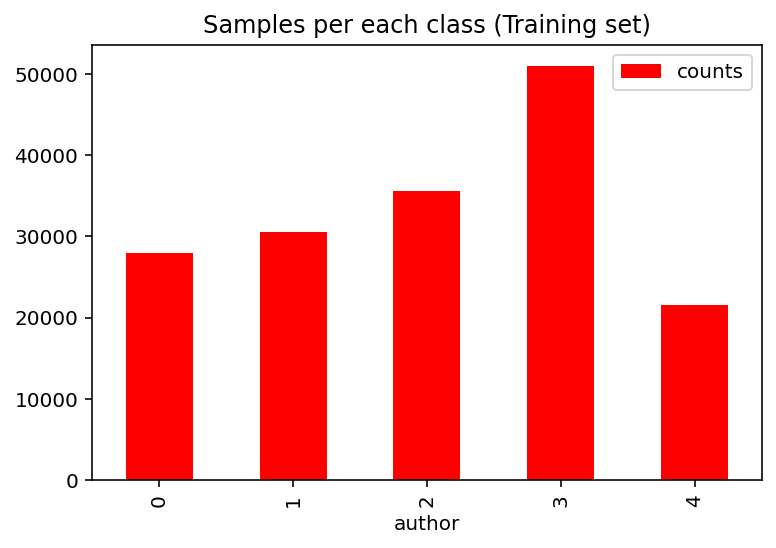

In [11]:
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [12]:
train['length']= train['text'].apply(len)
train['text'].duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
166636     True
166637     True
166638     True
166639     True
166640     True
Name: text, Length: 166641, dtype: bool

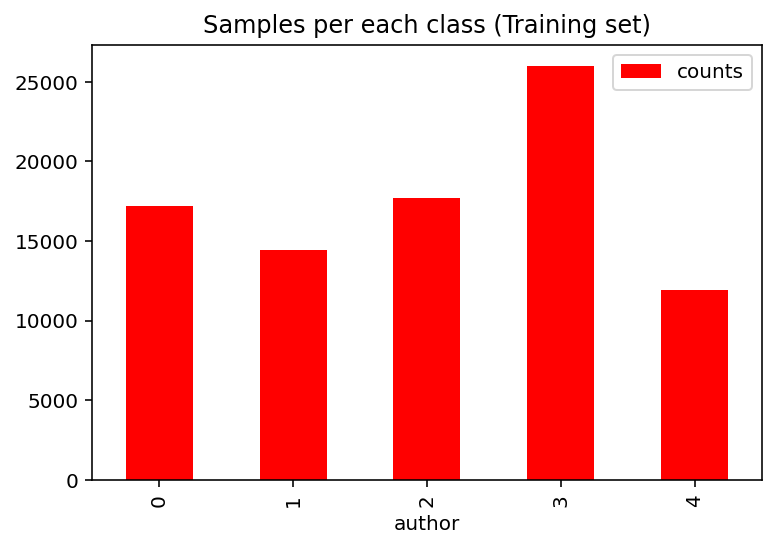

In [13]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [14]:
df = df.reset_index()

In [15]:
df[df['length']>500].describe()
df=df.drop(columns='level_0')

In [16]:
df['index'] = df['index'].reset_index()

In [17]:
df

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,129
1,1,sister asked suppose,2,20
2,2,engaged one day walked perusing janes last let...,1,191
3,3,captain porch keeping carefully way treacherou...,4,188
4,4,mercy gentlemen flung hands dont write anyway ...,3,123
...,...,...,...,...
87283,87283,though liberally provided friend funds sent be...,3,306
87284,87284,diningroom soon joined busily engaged separate...,1,73
87285,87285,one came books toilette,1,23
87286,87286,faces however tolerably calm no change visible...,1,138


<h2> Data Augemtation

In [18]:
train=df

In [19]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(87288,) (19617,) (87288,)


In [20]:
from sklearn.model_selection import train_test_split
SEED = 200
X_trn, X_val, y_trn, y_val = train_test_split(train.text, train.author, test_size=0.2, random_state=3,stratify= train.author)

In [21]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(trn)
sequences_train = tokenizer.texts_to_sequences(trn)
sequences_test = tokenizer.texts_to_sequences(tst)
sequences_validation = tokenizer.texts_to_sequences(X_val)

In [22]:
max_length = 500
from keras.preprocessing import sequence
x_train=sequence.pad_sequences(sequences_train,maxlen=max_length)
x_validation=sequence.pad_sequences(sequences_validation,maxlen=max_length)
tst=sequence.pad_sequences(sequences_test,maxlen=max_length)

print(f"Train set shape: {x_train.shape}\nValidation set shape: {x_validation.shape}\nTest set shape: {tst.shape}")

Train set shape: (87288, 500)
Validation set shape: (17458, 500)
Test set shape: (19617, 500)


In [23]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_trn.values.reshape(-1, 1))
y_validation_categorical=encoder.transform(train['author'].values.reshape(-1, 1))

In [24]:
print(f"Train set labels: {y_train_categorical.__len__()}\nValidation set labels: {y_validation_categorical.__len__()}")


Train set labels: 69830
Validation set labels: 87288


<h2> Glove 임베딩 

In [25]:
glove_file = './dataset/glove.6B/glove.6B.100d.txt'


In [26]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


In [27]:
word_index = tokenizer.word_index
max_words = tokenizer.num_words

In [28]:
max_words

500000

In [29]:
embedding_dim=100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i< max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None :
            embedding_matrix[i] = embedding_vector# 임베딩 인덱스에 없는 단어는 모두 0이 됨.

<h2> CNN 하이퍼 파라미터

In [50]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [31]:
def data(batch_size, time_steps, trn, y):
    """
    function that returns data to be fed into objective function and model is trained on it subsequently.
    """
    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)
    return  X_trn, X_val, y_trn, y_val

In [32]:
search_space = {
    #'batch_size': hp.choice('bs', [30,40,50,60,70]),
    #'time_steps': hp.choice('ts', [30,50,60,80,90]),
    'embedding_dim' : 100,
    'embedding_matrix' : embedding_matrix,
    'cnn1_nodes': hp.choice('units_lsmt1', [32,64,80]),
    'cnn1_dropouts': hp.uniform('dos_lstm1',0,0.5),
    
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes': hp.choice('units_dense', [10,16,32,40])
        }
        ]),
    "lr": hp.loguniform('lr',np.log(0.01), np.log(0.1)),
    "epochs": 30,
    "optimizer": "Adam"
}

<h2> 모델

In [33]:
from keras.layers import *
from keras import regularizers
from keras import Sequential,optimizers
from keras_sequential_ascii import keras2ascii

class CNNtext(Sequential):
    """
    This class extends  keras.sequencial in order to build our 
    model according to the designed architecture
    """
    #params for the convolutional layers
    __num_filters = 64
    __weight_decay = 1e-4
    #optimizers
    __adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    def __init__(self,max_length,number_of_classes,embedding_matrix=None,vocab_size=None,tokenizer=None):
        #creating the model heritance from Keras.sequencial
        super().__init__()
        #params for the embedding layer
        self.__embedding_dim=100 if embedding_matrix is None else embedding_matrix.shape[1]
        #self.__vocab_size=vocab_size if tokenizer is None else tokenizer.word_index.__len__()+1
        self.__vocab_size=vocab_size if tokenizer is None else max(tokenizer.index_word.keys())+1
        try:
            self.__max_length=max_length
            self.__number_of_classes=number_of_classes 
        except NameError as error:
            print("Error ",error," must be defined.")
            
        #defining layers
        #This layer will learn an embedding the vocab_size is the vocabulary learn from our tokenizer
        #the embedding dimension is defined by our selfs in this case we choose a dimension of 100
        #the input length is the maximum length of the documents we will use
        if embedding_matrix is None:
            self.add(Embedding(self.__vocab_size,
                               self.__embedding_dim,
                               input_length=self.__max_length,trainable=True))
        else:
            self.add(Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               weights=[embedding_matrix],
                               input_length=self.__max_length,
                               trainable=False))
        #then we apply a 1D conv layer that should apply filters to the sequence and generate features maps.
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #then we will get the most important features using a max pooling layer
        self.add(MaxPooling1D(2))
        #afterwards we apply a conv 1D layer to learn new features form the previous results
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #we select again the most important features
        self.add(GlobalMaxPooling1D())
        #then we apply dropout to improve the generalization
        self.add(Dropout(0.5))
        #then we will pass the results into a dense layer that will also learn some internal representation and we also use the l2 regularization
        self.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.__weight_decay)))
        #for the final layer we will use softmax to obtain the probabilities of each class.
        self.add(Dense(self.__number_of_classes, activation='softmax'))  
        #to compute the loss function we use binary_crossentropy
        #which is widely used for multi-classification problems
        #we also use the adam optimazer to learn the parameters(weights)
        #and minimize the loss function.
        # 몰랐는데 binary_crossentropy가 multi-classification 에 좋다고 하는군요.
        # binary_crossentropy는 반드시 binary-classification에만 써야 하는건줄 알았는데...
        self.compile(loss='categorical_crossentropy', optimizer=self.__adam, metrics=['accuracy'])

In [53]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
lrs = LearningRateScheduler(scheduler, verbose = 0)

In [51]:
tf.math.exp(-0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9048374>

In [36]:
#training params
batch_size = 64
num_epochs = 10

In [37]:
tokenizer.num_words

500000

In [38]:
max_length=500

In [39]:
CNN_BOW=CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)

In [40]:
keras2ascii(CNN_BOW)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         500
           Embedding   emb | -------------------   4707400    98.4%
                       #####    500  100
              Conv1D    \|/  -------------------     44864     0.9%
                relu   #####    500   64
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    250   64
              Conv1D    \|/  -------------------     28736     0.6%
                relu   #####    250   64
  GlobalMaxPooling1D   Y^max -------------------         0     0.0%
                       #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      2080     0.0%
                relu   #####          32
               Dense   XXXXX -------------------       165     0.0%
             softmax   #####           5


In [41]:
x_train.shape, y_train_categorical.shape, x_validation.shape, y_validation_categorical.shape

((87288, 500), (69830, 5), (17458, 500), (87288, 5))

In [42]:
n_fold = 5
n_class = 5
seed = 777

In [43]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [44]:
x_train.shape, y.shape

((87288, 500), (87288,))

In [45]:
tst.shape

(19617, 500)

In [46]:
from tensorflow.keras.utils import plot_model, to_categorical

In [54]:
p_val = np.zeros((x_train.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(x_train, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    lrs = LearningRateScheduler(scheduler, verbose = 0)
    clf = CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)
    clf.fit(x_train[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(x_train[i_val], to_categorical(y[i_val])),
            epochs=15,
            callbacks=[es,lrs])
    p_val[i_val, :] = clf.predict(x_train[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/15
2183/2183 [==============================] - 194s 89ms/step - loss: 1.0411 - accuracy: 0.5864 - val_loss: 0.7761 - val_accuracy: 0.7103
Epoch 2/15
2183/2183 [==============================] - 188s 86ms/step - loss: 0.6178 - accuracy: 0.7810 - val_loss: 0.7159 - val_accuracy: 0.7382
Epoch 3/15
2183/2183 [==============================] - 189s 86ms/step - loss: 0.4313 - accuracy: 0.8515 - val_loss: 0.7529 - val_accuracy: 0.7436
Epoch 4/15
2183/2183 [==============================] - 194s 89ms/step - loss: 0.2993 - accuracy: 0.9004 - val_loss: 0.8633 - val_accuracy: 0.7391
Epoch 5/15
2183/2183 [==============================] - 192s 88ms/step - loss: 0.1983 - accuracy: 0.9341 - val_loss: 1.0008 - val_accuracy: 0.7366
Epoch 00005: early stopping
training model for CV #2
Epoch 1/15
2183/2183 [==============================] - 184s 84ms/step - loss: 1.0342 - accuracy: 0.5933 - val_loss: 0.7926 - val_accuracy: 0.7037
Epoch 2/15
2183/2183 [==================

In [55]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  72.6411%
Log Loss (CV):   0.7529


In [56]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
# submission
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')
sample_submission[['0','1','2','3','4']] = p_tst
sample_submission

sample_submission.to_csv('open/sub/submission_CNN_shared_cv_lrs.csv', index = False, encoding = 'utf-8')
